In [3]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
import nglview as nv

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "../data"
print(HERE)

/home/dmm2017/Desktop/hackathon/smiles-against-covid/notebooks


In [5]:
ligand = [Path(DATA / "target.pdb")]
print(ligand)

[PosixPath('/home/dmm2017/Desktop/hackathon/smiles-against-covid/notebooks/../data/target.pdb')]


In [6]:
pdb_ids = [Path(file).stem.split("_")[0] for file in ligand]
pdb_ids

['target']

In [7]:
molecules = []
for mol_file in ligand:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")


O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.[H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)O)C([H])([H])C([H])([H])C(=O)O)C([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])O[H])C([H])([

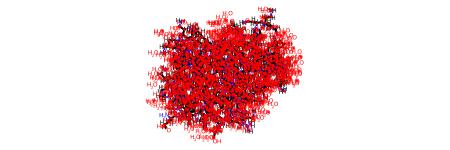

In [8]:
example_molecule = molecules[0]
example_molecule

In [9]:
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) / "BaseFeatures.fdef"))

# NBVAL_CHECK_OUTPUT
features = feature_factory.GetFeaturesForMol(example_molecule)
print(f"Number of features found: {len(features)}")

Number of features found: 1022


In [10]:
print(features)

(<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66350>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66510>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66580>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa665f0>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66660>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa666d0>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66740>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66190>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa663c0>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa662e0>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa667b0>, <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature object at 0x7f9c3fa66820>, <rdkit.Chem.rdMolChemicalFeatures.MolCh

In [11]:
# Cell with constants
DATADIR = Path("../data")
RANDOM_SEED = 2407

TMP_DIR = Path("../tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

In [12]:
print(train_df)

                                                 Smiles  Active
0                               COc1ccc2[nH]cc(CCN)c2c1   False
1                       CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl   False
2     O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...   False
3     Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...   False
4               Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1   False
...                                                 ...     ...
5552  O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...   False
5553                   Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1   False
5554                                    Oc1cccc2cccnc12   False
5555  OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...   False
5556                    CCCCNc1ccc(C(=O)OCCN(C)C)cc1.Cl   False

[5557 rows x 2 columns]


In [16]:
smile_molecules = [Chem.MolFromSmiles(smile) for smile in train_df["Smiles"]]
for molecule in smile_molecules:
    features = feature_factory.GetFeaturesForMol(molecule)
    print(f"Number of features found: {len(features)}")

Number of features found: 10
Number of features found: 9
Number of features found: 18
Number of features found: 17
Number of features found: 17
Number of features found: 4
Number of features found: 19
Number of features found: 12
Number of features found: 11
Number of features found: 12
Number of features found: 17
Number of features found: 11
Number of features found: 22
Number of features found: 10
Number of features found: 17
Number of features found: 18
Number of features found: 10
Number of features found: 8
Number of features found: 13
Number of features found: 17
Number of features found: 23
Number of features found: 14
Number of features found: 14
Number of features found: 10
Number of features found: 11
Number of features found: 15
Number of features found: 21
Number of features found: 13
Number of features found: 20
Number of features found: 19
Number of features found: 20
Number of features found: 10
Number of features found: 16
Number of features found: 15
Number of feature

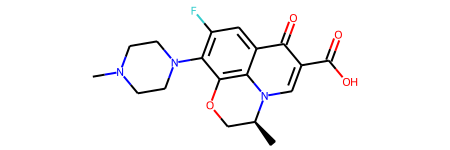

In [14]:
smile_molecules[38]

In [1]:
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdMolAlign import AlignMol
with open("text.text", 'w') as w:
    for i, mol in enumerate(smile_molecules):
        print("here")
        mols = [example_molecule, mol]
        print(1)
        AllChem.EmbedMolecule(example_molecule)
        AllChem.UFFOptimizeMolecule(example_molecule)
        try:
            mol = AllChem.ConstrainedEmbed(mol, example_molecule)
            print(str(i) + " " + str(nm.GetProp('EmbedRMS')))

        except:
            print("No match")
        continue

        mols[1]=Chem.AddHs(mols[1], addCoords=True)    #create a new 3D molecule  and add the TETHERED ATOMS property
        mcsResult=rdFMCS.FindMCS(mols,threshold=0.9,completeRingsOnly=True)    #find the maximum common substructure
        if mcsResult.smartsString and len(mcsResult.smartsString)>0 :
            patt = Chem.MolFromSmarts(mcsResult.smartsString,mergeHs=True)

        #keep only the core of the reference molecule
        ref=AllChem.ReplaceSidechains(example_molecule,patt)
        if ref:
            core=AllChem.DeleteSubstructs(ref,Chem.MolFromSmiles('*'))
            core.UpdatePropertyCache()
            core=Chem.AddHs(core, addCoords=True)    #create a new 3D molecule  and add the TETHERED ATOMS property

            newmol=Chem.Mol(mol)    #create a new instance of the ligand, as we will change the coordinates
            try:
                AllChem.ConstrainedEmbed(newmol,core)   #constrained minimization of newmol versus the core of the reference
            except:
                print("No core match")
            tethered_atom_ids=newmol.GetSubstructMatches(patt)
            #that's to get the atom ids only
            if tethered_atom_ids :
                t=tethered_atom_ids[0]
                t1=map(lambda x:x+1, list(t))
                ta=','.join(str(el) for el in t1)
                nm=Chem.AddHs(newmol, addCoords=True)    #create a new 3D molecule  and add the TETHERED ATOMS property
                nm.SetProp('TETHERED ATOMS',ta)
                try:
                    print(str(i) + " " + str(nm.GetProp('EmbedRMS')))
                except:
                    print("No match")#write to an sd file

NameError: name 'smile_molecules' is not defined